<a href="https://colab.research.google.com/github/atrbyg24/kilter-board/blob/main/kilter_tabular.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The Kilterboard is a standardized training tool for climbers.
It is a wall with an adjustable angle and screwed on holds
with LEDs which allows users to create their own climb and
comes in various sizes.

Climbs come with various levels of difficulties (grades). These
are initially set by the creater of the climb (setter) and users
who complete the climb can also submit their own grades to help
come to a concensus.

We shall use the data from the Kilterboard in order to develop a
model that can accurately grade climbs. Although the Kilterboard
boosts a large repository of climbs (almost 200,000), most users
only attempt the most popular climbs which can have up to 40,000+
ascents while a large portion of climbs have less than 5 ascents.

This hurts the user experience since some setters do not grade
their climbs accurately due to inexperience or lack of
climbing ability/knowledge. However if these climbs remain
unpopular, it is unlikely if a wrong grade will be changed as
there will not be enough user-submitted ratings to correct
the error.

This model will not only allow setters to set and grade climbs
more accurately but will also give the larger userbase access to
more climbs in their desired difficulty range outside of the most
popular climbs which users rely on due to their accurate grades.

Data for this project can be found at:
https://climbdex.fly.dev/

https://github.com/lemeryfertitta/Climbdex


In [1]:
pip install boardlib

Import all the libraries that we will need for this task.

In [37]:
import sqlite3
import numpy as np
import pandas as pd
import boardlib as bl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from xgboost import XGBRegressor

In [3]:
!boardlib database kilter 'content/drive/MyDrive/kilter.db'

Synchronizing database at content/drive/MyDrive/kilter.db
Synchronized 3 rows in kits
Synchronized 8335 rows in climbs
Synchronized 32912 rows in climb_stats
Synchronized 286 rows in beta_links
Synchronized 15 rows in shared_syncs


Let's examine the database structure so we can extract the data we need for our model.

In [4]:
conn = sqlite3.connect('content/drive/MyDrive/kilter.db')
cur = conn.cursor()

cur.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cur.fetchall()

for table in tables:
    print(table)

conn.close()

('shared_syncs',)
('products',)
('product_sizes',)
('holes',)
('leds',)
('products_angles',)
('layouts',)
('sets',)
('product_sizes_layouts_sets',)
('placement_roles',)
('users',)
('user_permissions',)
('user_syncs',)
('walls_sets',)
('climb_cache_fields',)
('attempts',)
('difficulty_grades',)
('climb_stats',)
('tags',)
('android_metadata',)
('circuits',)
('circuits_climbs',)
('kits',)
('climb_random_positions',)
('beta_links',)
('bids',)
('climbs',)
('placements',)
('walls',)
('ascents',)


There are a lot of tables, but not all of them are useful. Many of these tables are synced up to user data so they will be blank since we have not synced up any data.

By checking the 'products' table, we see that the database we are using contains information from other climbing boards as well like the Tension board.

The Kilterboard comes in various sizes and configurations designed for either home-use or a commercial gym. We will utilize the Kilter board with the Kilter board original layout in 16 x 12 Super Wide size since it encompasses all the smaller board sizes as well. This will give us access to more climbs overall.

To get the positions of all the holds on the Kilterboard, we will query the
'placements' table.

The necessary data we need for each climb is contained in the 'climbs' and 'climb_stats' tables so we will need to join these tables together. However we will not take every single climb. We will limit ourselves to climbs that have been ascended by at least 5 people and whose user-submitted rating aligns closely with the displayed difficulty of the climb.

The data for which holds are used and how they are used in each climb can be found in the 'frames' column in the 'climbs' table. This information is sorted as a string which follows the pattern pXXXXrXXpXXXXrXXpXXXXrXX... This string is to be read as follows:
pXXXX gives the placement XXXX where the hold is located
rXX gives the role XX for the hold. The different roles are start,middle,finish,foot. A climb begins with 1 or 2 start holds and ends with 1 or 2 finish holds. There are some routes that are intended to be circuits (i.e. 2+ routes chained together which are meant to train a climber's endurance). These are given by comma-separated strings so we need to filter these out of our data as well.

The full range of difficulties for climbs can be seen in the 'difficulty_grades' table. We will have to convert this to the V-grading scale. This is the most commonly used grading system in US commercial gyms.

In [5]:
conn = sqlite3.connect('content/drive/MyDrive/kilter.db')
cur = conn.cursor()
df = pd.read_sql_query(
    r"""
      WITH kilter_comm AS
      (
      SELECT
        cs.climb_uuid,
        cs.angle,
        ROUND(cs.display_difficulty) AS difficulty,
        cs.ascensionist_count,
        cs.difficulty_average,
        c.description,
        c.frames
        FROM climb_stats AS cs
          LEFT JOIN climbs AS c
            ON cs.climb_uuid = c.uuid
      WHERE cs.ascensionist_count >= 5
        AND c.layout_id = 1
        AND ABS(ROUND(cs.display_difficulty) - cs.difficulty_average) < 0.2
        AND c.frames NOT LIKE '%,%'
      )
      SELECT * FROM kilter_comm
    """,conn)
kilter_comm_holds = pd.read_sql_query(
    "SELECT id AS placement FROM placements WHERE layout_id = 1",conn)
conn.close()


In [6]:
import re

"""
Create dataset with encoding for each board climb based on
whether or not a hold is utilized in the climb. Also create columns for
when a hold is a start hold or a finish hold.
0 - not used
1 - foothold
2 - handhold
"""
climb_data = []
for hold in kilter_comm_holds['placement']:
  y = pd.DataFrame({f'hole_{hold}':[0]*df.shape[0],
                    f'hole_{hold}_start':[0]*df.shape[0],
                    f'hole_{hold}_finish':[0]*df.shape[0]},dtype= 'int')
  climb_data.append(y)
climb_data = pd.concat(climb_data, axis=1)
climb_data = pd.concat([df,climb_data], axis=1)
climb_data.shape

def has_no_match(description):
  """
  Checks if the climb allows for matching hands on holds or not. Look in
  description for the string 'no match', but exclude strings such as
  'piano match'.
  """
  return 1 if bool(re.search(r'\bno match',
                            description, flags=re.IGNORECASE)) else 0

def campus(description):
  """
  Checks if the climb intends for the climb to campus or not. Look in
  description for the string 'campus'.
  """
  return 1 if bool(re.search(r'campus',description,flags=re.IGNORECASE)) else 0

climb_data['no_match_flag'] = climb_data['description'].apply(has_no_match)
climb_data['campus_flag'] = climb_data['description'].apply(campus)


In [7]:
def iterframes(df):
    """
    Using frames, fill in dataframe for each hold used in the climb.
    Furthermore label if a hold is utilized at the start or finish
    of the climb. If a hold is a handhold, label it as a '1', if it is a
    foothold, label it as a '1', if it is  not used, label it as a '0'.
    """
    for index, row in df.iterrows():
      for placement_role in row['frames'].split("p")[1:]:
        placement, role = placement_role.split("r")
        hold_num = int(placement)
        role_num = int(role)
        if role_num == 12:
          df.at[index, f'hole_{hold_num}_start'] = 1
          df.at[index, f'hole_{hold_num}'] = 2
        if role_num == 13:
          df.at[index, f'hole_{hold_num}'] = 2
        if role_num == 14:
          df.at[index, f'hole_{hold_num}_finish'] = 1
          df.at[index, f'hole_{hold_num}'] = 2
        if role_num == 15:
          df.at[index, f'hole_{hold_num}'] = 1
    return df

In [8]:
iterframes(climb_data)

,climb_uuid,angle,difficulty,ascensionist_count,difficulty_average,description,frames,hole_1447,hole_1447_start,hole_1447_finish,...,hole_4843_start,hole_4843_finish,hole_4844,hole_4844_start,hole_4844_finish,hole_4845,hole_4845_start,hole_4845_finish,no_match_flag,campus_flag
0,0047d90951b5425dbf64572bef3e8593,25,19.0,7,18.8571,no match,p1108r12p1129r12p1178r13p1246r13p1284r13p1320r...,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,004A22C3CED04C0CA98D5C0BE78F4298,45,23.0,6,22.8333,No matchies,p1222r12p1238r12p1274r13p1291r13p1358r13p1390r...,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,012CF0D42B9E421DA7E6389604FF16BE,40,21.0,5,20.8000,,p1128r12p1134r12p1146r15p1170r15p1183r15p1234r...,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,016E673449E54EFAA8A2597642E423F9,30,16.0,5,16.2000,,p1124r12p1127r12p1176r13p1196r13p1228r13p1265r...,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,025E7533F07247D9A0FC7C39A4AFA048,30,19.0,7,18.8571,A 5’3” climber set this...,p1083r13p1115r12p1127r12p1152r15p1197r13p1217r...,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31579,FFCF27FC2BD7401BA6C75C6EA8938699,50,27.0,15,27.0000,,p1136r12p1190r13p1256r13p1304r13p1325r13p1349r...,1,0,0,...,0,0,0,0,0,0,0,0,0,0
31580,FFCF27FC2BD7401BA6C75C6EA8938699,60,28.0,27,27.8519,,p1136r12p1190r13p1256r13p1304r13p1325r13p1349r...,1,0,0,...,0,0,0,0,0,0,0,0,0,0
31581,FFD101806A364A7B8FB9E5AFF38CC3ED,60,23.0,11,22.9909,Look up “corn parts” on google,p1152r15p1165r12p1180r12p1233r13p1247r13p1271r...,0,0,0,...,0,0,0,0,0,0,0,0,0,0
31582,FFDC08A24B31401D92E71C0F421CA94A,40,20.0,46,19.8478,,p1161r15p1214r12p1247r12p1303r13p1334r13p1389r14,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
def total_handholds(row):
  """
  Return the total number of handholds used in the climb.
  """
  total = 0
  for col in row.index:
    if 'hole_' in col and 'start' not in col and 'finish' not in col:
      if row[col] == 2:
        total += 1
  row['total_handholds'] = total
  return row

def total_footholds(row):
  """
  Return the total number of footholds used in the climb.
  """
  total = 0
  for col in row.index:
    if 'hole_' in col and 'start' not in col and 'finish' not in col:
      if row[col] == 1:
        total += 1
  row['total_footholds'] = total
  return row

climb_data = climb_data.apply(total_handholds, axis = 1)
climb_data = climb_data.apply(total_footholds, axis = 1)


In [10]:
def vgrades(df):
  """
  Convert difficulty rating for climbs to the V-grade scale.
  Conversion can be found in the difficulty_grades table in
  boardlib database.
  """
  v_grade_map = {
      10: 0, 11: 0, 12: 0,
      13: 1, 14: 1,
      15: 2,
      16: 3, 17: 3,
      18: 4, 19: 4,
      20: 5, 21: 5,
      22: 6,
      23: 7,
      24: 8, 25: 8,
      26: 9,
      27: 10,
      28: 11,
      29: 12,
      30: 13
  }
  df['v_grade'] = df['difficulty'].map(v_grade_map)
  return df

In [11]:
vgrades(climb_data)

<ipython-input-10-a5359bb8dae6>:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['v_grade'] = df['difficulty'].map(v_grade_map)


,climb_uuid,angle,difficulty,ascensionist_count,difficulty_average,description,frames,hole_1447,hole_1447_start,hole_1447_finish,...,hole_4844_start,hole_4844_finish,hole_4845,hole_4845_start,hole_4845_finish,no_match_flag,campus_flag,total_handholds,total_footholds,v_grade
0,0047d90951b5425dbf64572bef3e8593,25,19.0,7,18.8571,no match,p1108r12p1129r12p1178r13p1246r13p1284r13p1320r...,0,0,0,...,0,0,0,0,0,1,0,8,4,4
1,004A22C3CED04C0CA98D5C0BE78F4298,45,23.0,6,22.8333,No matchies,p1222r12p1238r12p1274r13p1291r13p1358r13p1390r...,0,0,0,...,0,0,0,0,0,1,0,6,4,7
2,012CF0D42B9E421DA7E6389604FF16BE,40,21.0,5,20.8000,,p1128r12p1134r12p1146r15p1170r15p1183r15p1234r...,0,0,0,...,0,0,0,0,0,0,0,6,7,5
3,016E673449E54EFAA8A2597642E423F9,30,16.0,5,16.2000,,p1124r12p1127r12p1176r13p1196r13p1228r13p1265r...,0,0,0,...,0,0,0,0,0,0,0,10,7,3
4,025E7533F07247D9A0FC7C39A4AFA048,30,19.0,7,18.8571,A 5’3” climber set this...,p1083r13p1115r12p1127r12p1152r15p1197r13p1217r...,0,0,0,...,0,0,0,0,0,0,0,11,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31579,FFCF27FC2BD7401BA6C75C6EA8938699,50,27.0,15,27.0000,,p1136r12p1190r13p1256r13p1304r13p1325r13p1349r...,1,0,0,...,0,0,0,0,0,0,0,8,4,10
31580,FFCF27FC2BD7401BA6C75C6EA8938699,60,28.0,27,27.8519,,p1136r12p1190r13p1256r13p1304r13p1325r13p1349r...,1,0,0,...,0,0,0,0,0,0,0,8,4,11
31581,FFD101806A364A7B8FB9E5AFF38CC3ED,60,23.0,11,22.9909,Look up “corn parts” on google,p1152r15p1165r12p1180r12p1233r13p1247r13p1271r...,0,0,0,...,0,0,0,0,0,0,0,8,2,7
31582,FFDC08A24B31401D92E71C0F421CA94A,40,20.0,46,19.8478,,p1161r15p1214r12p1247r12p1303r13p1334r13p1389r14,0,0,0,...,0,0,0,0,0,0,0,5,1,5


In [13]:
climb_data.head()

,climb_uuid,angle,difficulty,ascensionist_count,difficulty_average,description,frames,hole_1447,hole_1447_start,hole_1447_finish,...,hole_4844_start,hole_4844_finish,hole_4845,hole_4845_start,hole_4845_finish,no_match_flag,campus_flag,total_handholds,total_footholds,v_grade
0,0047d90951b5425dbf64572bef3e8593,25,19.0,7,18.8571,no match,p1108r12p1129r12p1178r13p1246r13p1284r13p1320r...,0,0,0,...,0,0,0,0,0,1,0,8,4,4
1,004A22C3CED04C0CA98D5C0BE78F4298,45,23.0,6,22.8333,No matchies,p1222r12p1238r12p1274r13p1291r13p1358r13p1390r...,0,0,0,...,0,0,0,0,0,1,0,6,4,7
2,012CF0D42B9E421DA7E6389604FF16BE,40,21.0,5,20.8000,,p1128r12p1134r12p1146r15p1170r15p1183r15p1234r...,0,0,0,...,0,0,0,0,0,0,0,6,7,5
3,016E673449E54EFAA8A2597642E423F9,30,16.0,5,16.2000,,p1124r12p1127r12p1176r13p1196r13p1228r13p1265r...,0,0,0,...,0,0,0,0,0,0,0,10,7,3
4,025E7533F07247D9A0FC7C39A4AFA048,30,19.0,7,18.8571,A 5’3” climber set this...,p1083r13p1115r12p1127r12p1152r15p1197r13p1217r...,0,0,0,...,0,0,0,0,0,0,0,11,4,4


In [14]:
climb_data.describe()

,angle,difficulty,ascensionist_count,difficulty_average,hole_1447,hole_1447_start,hole_1447_finish,hole_1073,hole_1073_start,hole_1073_finish,...,hole_4844_start,hole_4844_finish,hole_4845,hole_4845_start,hole_4845_finish,no_match_flag,campus_flag,total_handholds,total_footholds,v_grade
count,31584.000000,31584.000000,31584.000000,31584.000000,31584.000000,31584.0,31584.000000,31584.000000,31584.000000,31584.0,...,31584.0,31584.0,31584.0,31584.0,31584.0,31584.000000,31584.000000,31584.000000,31584.000000,31584.000000
mean,38.780237,19.646910,210.299487,19.627577,0.037297,0.0,0.000032,0.014374,0.000063,0.0,...,0.0,0.0,0.0,0.0,0.0,0.108473,0.003198,8.029065,4.447537,4.908783
std,12.249560,4.488737,1106.188779,4.469385,0.189993,0.0,0.005627,0.122439,0.007957,0.0,...,0.0,0.0,0.0,0.0,0.0,0.310981,0.056460,3.299887,2.671026,2.814468
min,0.000000,10.000000,5.000000,10.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,1.000000,0.000000,0.000000
25%,30.000000,16.000000,6.000000,16.083300,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,7.000000,3.000000,3.000000
50%,40.000000,20.000000,12.000000,20.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,8.000000,4.000000,5.000000
75%,45.000000,23.000000,43.000000,22.957600,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,9.000000,6.000000,7.000000
max,70.000000,30.000000,43785.000000,30.000000,2.000000,0.0,1.000000,2.000000,1.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,1.000000,1.000000,234.000000,72.000000,13.000000


In [15]:
climb_data[climb_data['total_handholds'] > 40]

,climb_uuid,angle,difficulty,ascensionist_count,difficulty_average,description,frames,hole_1447,hole_1447_start,hole_1447_finish,...,hole_4844_start,hole_4844_finish,hole_4845,hole_4845_start,hole_4845_finish,no_match_flag,campus_flag,total_handholds,total_footholds,v_grade
8621,F51C963EA6674EBD891CD371C1A413D4,30,10.0,5,10.0,,p1080r15p1081r15p1082r15p1097r15p1098r15p1099r...,0,0,0,...,0,0,0,0,0,0,0,136,15,0
13311,9009dafe7e6c49acb17753e2286b43db,30,11.0,6,11.0,,p1090r14p1091r13p1092r15p1093r12p1094r14p1095r...,0,0,0,...,0,0,0,0,0,0,0,234,72,0
14391,9009dafe7e6c49acb17753e2286b43db,0,10.0,5,10.0,,p1090r14p1091r13p1092r15p1093r12p1094r14p1095r...,0,0,0,...,0,0,0,0,0,0,0,234,72,0
17021,9009dafe7e6c49acb17753e2286b43db,40,10.0,9,10.0,,p1090r14p1091r13p1092r15p1093r12p1094r14p1095r...,0,0,0,...,0,0,0,0,0,0,0,234,72,0
26239,9009dafe7e6c49acb17753e2286b43db,45,10.0,6,10.0,,p1090r14p1091r13p1092r15p1093r12p1094r14p1095r...,0,0,0,...,0,0,0,0,0,0,0,234,72,0


In [16]:
climb_data[climb_data['total_footholds'] > 30]

,climb_uuid,angle,difficulty,ascensionist_count,difficulty_average,description,frames,hole_1447,hole_1447_start,hole_1447_finish,...,hole_4844_start,hole_4844_finish,hole_4845,hole_4845_start,hole_4845_finish,no_match_flag,campus_flag,total_handholds,total_footholds,v_grade
13311,9009dafe7e6c49acb17753e2286b43db,30,11.0,6,11.0,,p1090r14p1091r13p1092r15p1093r12p1094r14p1095r...,0,0,0,...,0,0,0,0,0,0,0,234,72,0
14391,9009dafe7e6c49acb17753e2286b43db,0,10.0,5,10.0,,p1090r14p1091r13p1092r15p1093r12p1094r14p1095r...,0,0,0,...,0,0,0,0,0,0,0,234,72,0
17021,9009dafe7e6c49acb17753e2286b43db,40,10.0,9,10.0,,p1090r14p1091r13p1092r15p1093r12p1094r14p1095r...,0,0,0,...,0,0,0,0,0,0,0,234,72,0
26239,9009dafe7e6c49acb17753e2286b43db,45,10.0,6,10.0,,p1090r14p1091r13p1092r15p1093r12p1094r14p1095r...,0,0,0,...,0,0,0,0,0,0,0,234,72,0


In [17]:
climb_data.drop(climb_data[climb_data['total_handholds'] > 40].index, inplace = True)

In [18]:
climb_data.describe()

,angle,difficulty,ascensionist_count,difficulty_average,hole_1447,hole_1447_start,hole_1447_finish,hole_1073,hole_1073_start,hole_1073_finish,...,hole_4844_start,hole_4844_finish,hole_4845,hole_4845_start,hole_4845_finish,no_match_flag,campus_flag,total_handholds,total_footholds,v_grade
count,31579.000000,31579.000000,31579.000000,31579.000000,31579.000000,31579.0,31579.000000,31579.000000,31579.000000,31579.0,...,31579.0,31579.0,31579.0,31579.0,31579.0,31579.000000,31579.000000,31579.000000,31579.000000,31579.000000
mean,38.781785,19.648406,210.331803,19.629069,0.037303,0.0,0.000032,0.014377,0.000063,0.0,...,0.0,0.0,0.0,0.0,0.0,0.108490,0.003198,7.996390,4.438646,4.909560
std,12.248335,4.487515,1106.273370,4.468161,0.190008,0.0,0.005627,0.122449,0.007958,0.0,...,0.0,0.0,0.0,0.0,0.0,0.311003,0.056464,1.975638,2.560051,2.814013
min,0.000000,10.000000,5.000000,10.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,1.000000,0.000000,0.000000
25%,30.000000,16.000000,6.000000,16.083300,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,7.000000,3.000000,3.000000
50%,40.000000,20.000000,12.000000,20.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,8.000000,4.000000,5.000000
75%,45.000000,23.000000,43.000000,22.957600,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,9.000000,6.000000,7.000000
max,70.000000,30.000000,43785.000000,30.000000,2.000000,0.0,1.000000,2.000000,1.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,1.000000,1.000000,35.000000,28.000000,13.000000


In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

<Axes: xlabel='v_grade', ylabel='Count'>

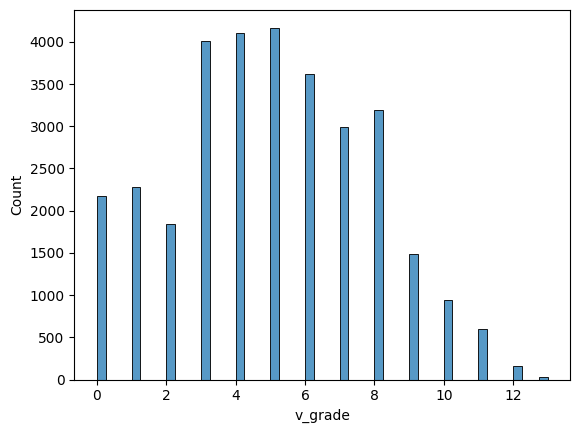

In [20]:
sns.histplot(climb_data['v_grade'])

In [21]:
mean = climb_data['v_grade'].mean()
median = climb_data['v_grade'].median()
skew = climb_data['v_grade'].skew()
print(f"Mean: {mean}\nMedian: {median}\nSkew: {skew}")

Mean: 4.909560150733082
Median: 5.0
Skew: 0.1281870205236417


We see that the data is slightly skewed with very few climbs
in the higher grade ranges (V10 and above).

<Axes: xlabel='angle', ylabel='Count'>

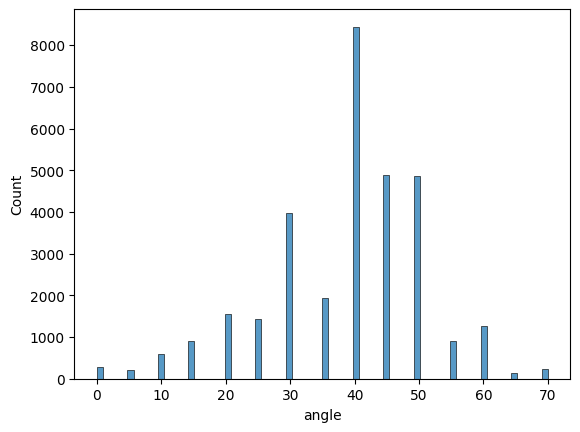

In [22]:
sns.histplot(climb_data["angle"])

We see that by far the most common angle for the board is 40 degrees. This is most likely due to the fact that 40 degrees is the default angle and some gyms do not have boards with adjustable angles. Furthermore angles of the form x0 (20,30,40,etc.) are more common than angles of the form x5.

<Axes: xlabel='total_handholds', ylabel='Count'>

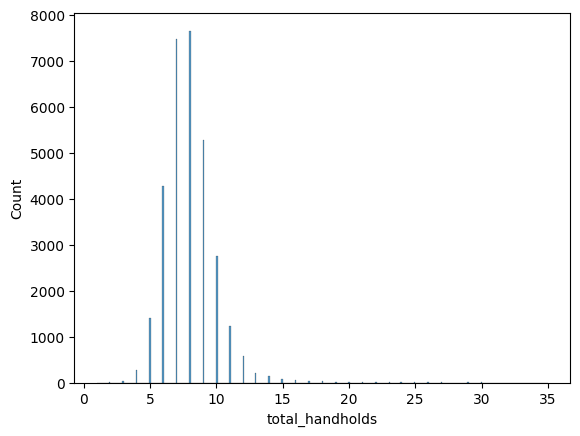

In [23]:
sns.histplot(climb_data["total_handholds"])

<Axes: xlabel='total_footholds', ylabel='Count'>

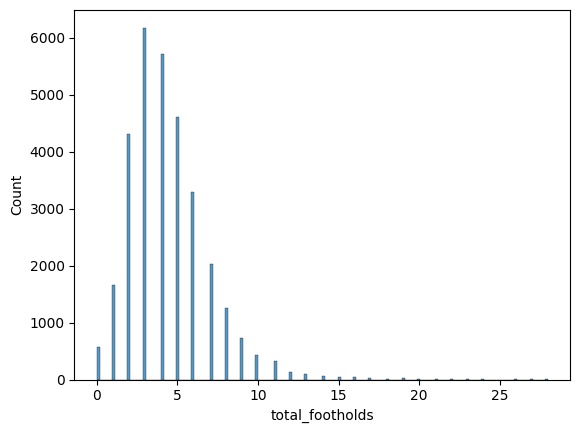

In [24]:
sns.histplot(climb_data["total_footholds"])

In [25]:
climb_data.drop(columns=['difficulty','climb_uuid','ascensionist_count','difficulty_average','description','frames'],inplace=True)

In [26]:
scaler = StandardScaler()

climb_data[['angle', 'total_handholds', 'total_footholds']] = scaler.fit_transform(climb_data[['angle', 'total_handholds', 'total_footholds']])


Let us first see how well a simple model can predict using
just a few key features and then we will try more complicated
models using more features later on.



In [27]:
simple_climb_data = climb_data.copy()[['angle','v_grade','no_match_flag','campus_flag','total_handholds','total_footholds']]

In [28]:
simple_climb_data.corrwith(simple_climb_data['v_grade'])

,0
angle,0.444388
v_grade,1.000000
no_match_flag,0.242468
campus_flag,0.017167
total_handholds,-0.246503
total_footholds,-0.250941


The correlation of the features selected agrees with physical intuition:

 As the angle of a climb gets steeper, generally the climb gets hard. (Sidenote: the angle of the wall is measured from an imaginary line perpendicular to the ground so 0 degrees would be a perfectly vertical wall and 90 degrees would be a horizontal wall.)

 If a climb does not allow for matching, the climb will might get harder since it restricts some of your movement patterns and forces a climber to make larger moves between holds which is generally more difficult.

 Interestingly the 'campus_flag' feature is not very correlated with 'v_grade'. Usually being forced to campus a climb (i.e. not use your feet) requires a lot more physical strength which can make a climb harder. However sometimes it is actually easier to campus than not (angle could be very steep and/or the footholds are bad which makes it more difficult to use your feet than to simply ignore them).

 The fact that 'total_handholds' and 'total_footholds' are negatively correlated also makes sense. The fact that there are more holds means that the on average, the distance between holds is smaller so moving between holds is easier. Furthermore lower grade climbs usually give you more handholds and footholds so you are not forced into awkward positions when climbing.

In [29]:
simple_climb_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31579 entries, 0 to 31583
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   angle            31579 non-null  float64
 1   v_grade          31579 non-null  int64  
 2   no_match_flag    31579 non-null  int64  
 3   campus_flag      31579 non-null  int64  
 4   total_handholds  31579 non-null  float64
 5   total_footholds  31579 non-null  float64
dtypes: float64(3), int64(3)
memory usage: 1.7 MB


We will treat this problem as an ordinal regression problem.
We are trying to predict the difficulty of the climb ('v_grade')
which takes discrete integer values from 0 to 13. These values
have an ordering; 0 is considered the easiest while 13 is consider
the most difficult. However the jumps in difficulty are not the same.
For instance, the actual difficulty jump from V0 to V1 is much smaller than
the jump from V9 to V10 even though the difference in grades is just '1' in
both cases.

In [38]:
X = simple_climb_data.drop('v_grade', axis=1)
y = simple_climb_data['v_grade']

n = simple_climb_data.shape[0]
p = simple_climb_data.shape[1]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = rf_model.predict(X_test)
y_pred_rf_round = np.round(y_pred_rf)

# Evaluate the model
rmse_rf = mean_squared_error(y_test, y_pred_rf_round, squared=False)
print(f"Root Mean Squared Error (Random Forest): {rmse_rf}")
r2_rf = r2_score(y_test, y_pred_rf_round)
print(f"R^2 Score (Random Forest): {r2_rf}")
ar2_rf = 1 - (1-r2_rf)*(n-1)/(n-p-1)
print(f"Adjusted R^2 Score (Random Forest): {ar2_rf}")

# Create and train the Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_lr = lr_model.predict(X_test)

# Round predictions to the nearest integer
y_pred_lr_round = np.round(y_pred_lr)

# Evaluate the model
rmse_lr = mean_squared_error(y_test, y_pred_lr_round, squared=False)
print(f"Root Mean Squared Error (Linear regression): {rmse_lr}")
r2_lr = r2_score(y_test, y_pred_lr_round)
print(f"R^2 Score (Linear regression): {r2_lr}")
ar2_lr = 1 - (1-r2_lr)*(n-1)/(n-p-1)
print(f"Adjusted R^2 Score (Linear regression): {ar2_lr}")

# Create and train the XGBoost model
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_xgb = xgb_model.predict(X_test)
y_pred_xgb_round = np.round(y_pred_xgb)

# Evaluate the model
rmse_xgb = mean_squared_error(y_test, y_pred_xgb_round, squared=False)
print(f"Root Mean Squared Error (XGBoost): {rmse_xgb}")
r2_xgb = r2_score(y_test, y_pred_xgb_round)
print(f"R^2 Score (XGBoost): {r2_xgb}")
ar2_xgb = 1 - (1-r2_xgb)*(n-1)/(n-p-1)
print(f"Adjusted R^2 Score (XGBoost): {ar2_xgb}")

Root Mean Squared Error (Random Forest): 2.4224841352807953
R^2 Score (Random Forest): 0.2605637236126097
Adjusted R^2 Score (Random Forest): 0.2604231998048584
Root Mean Squared Error (Linear regression): 2.406911622643152
R^2 Score (Linear regression): 0.2700398393898661
Adjusted R^2 Score (Linear regression): 0.26990111644030124
Root Mean Squared Error (XGBoost): 2.3810192547682067
R^2 Score (XGBoost): 0.28566046813426993
Adjusted R^2 Score (XGBoost): 0.2855247137572524


Now let us create some models using the extra features we created which incorporate the hold data of climbs.

In [39]:
X = climb_data.drop('v_grade', axis=1)
y = climb_data['v_grade']

n = climb_data.shape[0]
p = climb_data.shape[1]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = rf_model.predict(X_test)
y_pred_rf_round = np.round(y_pred_rf)

# Evaluate the model
rmse_rf = mean_squared_error(y_test, y_pred_rf_round, squared=False)
print(f"Root Mean Squared Error (Random Forest): {rmse_rf}")
r2_rf = r2_score(y_test, y_pred_rf_round)
print(f"R^2 Score (Random Forest): {r2_rf}")
ar2_rf = 1 - (1-r2_rf)*(n-1)/(n-p-1)
print(f"Adjusted R^2 Score (Random Forest): {ar2_rf}")

# Create and train the Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_lr = lr_model.predict(X_test)

# Round predictions to the nearest integer
y_pred_lr_round = np.round(y_pred_lr)

# Evaluate the model
rmse_lr = mean_squared_error(y_test, y_pred_lr_round, squared=False)
print(f"Root Mean Squared Error (Linear regression): {rmse_lr}")
r2_lr = r2_score(y_test, y_pred_lr_round)
print(f"R^2 Score (Linear regression): {r2_lr}")
ar2_lr = 1 - (1-r2_lr)*(n-1)/(n-p-1)
print(f"Adjusted R^2 Score (Linear regression): {ar2_lr}")

# Create and train the XGBoost model
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_xgb = xgb_model.predict(X_test)
y_pred_xgb_round = np.round(y_pred_xgb)

# Evaluate the model
rmse_xgb = mean_squared_error(y_test, y_pred_xgb_round, squared=False)
print(f"Root Mean Squared Error (XGBoost): {rmse_xgb}")
r2_xgb = r2_score(y_test, y_pred_xgb_round)
print(f"R^2 Score (XGBoost): {r2_xgb}")
ar2_xgb = 1 - (1-r2_xgb)*(n-1)/(n-p-1)
print(f"Adjusted R^2 Score (XGBoost): {ar2_xgb}")

Root Mean Squared Error (Random Forest): 1.417009669263613
R^2 Score (Random Forest): 0.7469976836059656
Adjusted R^2 Score (Random Forest): 0.7291393020378758
Root Mean Squared Error (Linear regression): 203635998547.01913
R^2 Score (Linear regression): -5.225020263074986e+21
Adjusted R^2 Score (Linear regression): -5.593832718584957e+21
Root Mean Squared Error (XGBoost): 1.357607047996624
R^2 Score (XGBoost): 0.7677653394462266
Adjusted R^2 Score (XGBoost): 0.7513728603550632


Note that the XGBoost model performs the best while Linear Regression
performs extremely poorly since 'climb_data' is very sparse compared to
'simple_climb_data' (for a given climb, the majority of the hold features are 0).

By comparing the adjusted R^2 scores, we see that models perform better on the larger dataset 'climb_data' as opposed to the smaller 'simple_climb_data' dataset.